# Sentiment Analysis performance benchmark

In general, documents with similar sentiments, would be close to each other in the embeddings feature space. This can become another method to judge the performance of sentiment analysis models.

In this work, we aim to perform a benchmark of recent sentiment analysis works and models, reproduce their results, and judge their performance in comparison to baseline methods.

This work has the following plan :

- Understanding the data
- Text Preprocessing

Throughout this project, we are working with a clean Ubuntu 20.04 distribution, on Python 3.7. We are going to use libraries such as Pytorch 1.8 and Tensorflow 2, which would be using GPU. For installation of dependencis, you can install them using the `requirements.txt` file. More details can be found in the `README.md` file. You can find below the specs of the GPU we have been using for our experiments.

In [1]:
!nvidia-smi

Mon Dec  7 22:09:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    On   | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P0    27W /  N/A |    396MiB /  6078MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### I - Understanding the data

We would be working throughout this experiment on a Twitter dataset of complains and reviews of people about airline companies. These reviews got a sentiment already labelled, even though its apparent it was also generated with another model. This might incur incorrect labels, but as long as the models we use are trained on the same dataset, it would still fit our comparison purpose, even though it won't have much use in production. While this dataset is limiting, especially in terms of size, it would also be a good baseline to start our work with.

In [64]:
import pandas as pd
import string

In [3]:
df = pd.read_csv('tweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
tweets = df[['tweet_id','text','airline_sentiment','airline_sentiment_confidence']]

In [6]:
tweets.head()

,tweet_id,text,airline_sentiment,airline_sentiment_confidence
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral,1.0000
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive,0.3486
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative,1.0000
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative,1.0000


In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   text                          14640 non-null  object 
 2   airline_sentiment             14640 non-null  object 
 3   airline_sentiment_confidence  14640 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 457.6+ KB


In [8]:
tweets.isnull().sum()

tweet_id                        0
text                            0
airline_sentiment               0
airline_sentiment_confidence    0
dtype: int64

In [9]:
tweets['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [10]:
print("Size of neutrals is :: " + str(tweets['airline_sentiment'][tweets['airline_sentiment']=='neutral'].shape[0]))
print("Size of positives is :: " + str(tweets['airline_sentiment'][tweets['airline_sentiment']=='positive'].shape[0]))
print("Size of negatives is :: " + str(tweets['airline_sentiment'][tweets['airline_sentiment']=='negative'].shape[0]))

Size of neutrals is :: 3099
Size of positives is :: 2363
Size of negatives is :: 9178


In [23]:
print(tweets['text'][1000])

@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status should matter.


### II - Text preprocessing

In [77]:
print(tweets['text'][1000])
print(tweets['text'][10])

@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status should matter.
@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24


In [93]:
# returns the sum of dataframe columns
def get_tags(row):
    
    splits = row['text'].split(' ')
    row['tags'] = ''.join(e for e in splits[0] if e.isalnum()).lower()   
    row['text'] = splits[1] + ' '.join(splits[2:])
    return row

In [94]:
df = tweets.apply(get_tags,axis=1)

In [96]:
counter = df.groupby(['tags'])['tweet_id'].count()

In [104]:
counter = counter[counter>21]

<AxesSubplot:xlabel='tags'>

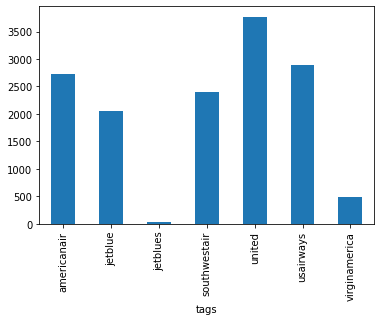

In [105]:
counter.plot.bar()